In [1]:
from dataset import Dataset
import numpy as np
import pandas as pd
import vectorbt as vbt
import pandas_ta as ta
import warnings
warnings.simplefilter(action='ignore')


In [2]:
data_binance = Dataset().get_data(days=360, ticker='BTCUSDT', ts='1h')


In [3]:
data = data_binance.copy()
candles = data.ta.cdl_pattern(name='all')
data = pd.concat([data, candles], axis=1)


In [7]:
data['cuts_volume'] = pd.cut(data['volume'], bins=12, labels=False)
data['cuts_volume'].value_counts(True)

0     0.815132
1     0.151203
2     0.022328
3     0.006478
4     0.002776
5     0.000694
6     0.000463
8     0.000463
7     0.000231
11    0.000116
9     0.000116
Name: cuts_volume, dtype: float64

In [8]:
target_names = []
fees = 0.001
for i in range(1, 13):
    name = f'expected_chg_{i}'
    target_names.append(name)
    data[name] = data['close'].pct_change(i).shift(-i)
    data[name] = data[name] - fees


In [10]:
data.groupby(['CDL_HAMMER', 'cuts_volume'])['expected_chg_1']\
    .agg(['sum', 'mean', 'size'])\
    .where(lambda x: (x['mean'] > 0.001) | (x['mean'] < -0.001))\
    .where(lambda x: x['size'] > 30)\
    .dropna()


sum      mean   size
CDL_HAMMER cuts_volume                           
0.0        2           -0.375913 -0.001968  191.0
           3            0.059550  0.001103   54.0
100.0      0           -0.212034 -0.001368  155.0

 1    0.593548
-1    0.406452
Name: returns_dir, dtype: float64


<AxesSubplot:xlabel='time'>

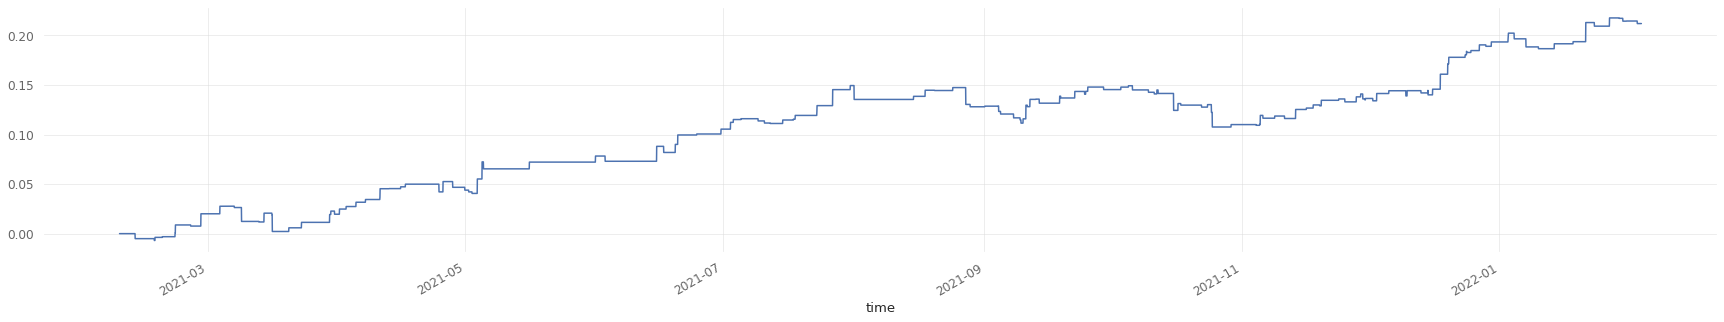

In [12]:
data['signal'] = np.where(
    (data['CDL_HAMMER'] == 100) & (data['cuts_volume'] == 0),
    -1, 0
)
data['returns_strategy'] = data['signal'] * data['expected_chg_1']
data['returns_dir'] = np.where(data['returns_strategy'] > 0, 1, 0)
data['returns_dir'] = np.where(data['returns_strategy'] < 0, -1, data['returns_dir'])
print(data[data['returns_dir'] != 0]['returns_dir'].value_counts(True))
data['cumreturns'] = data['returns_strategy'].cumsum()
data['cumreturns'].plot(figsize=(30, 5))

In [13]:
rets = data['cumreturns']
rets_acc = rets.vbt.returns(freq='1h')
rets_acc.stats()

Start                        2021-02-08 01:00:00
End                          2022-02-03 17:00:00
Period                         360 days 04:00:00
Total Return [%]                             inf
Annualized Return [%]                        inf
Annualized Volatility [%]             540.105878
Max Drawdown [%]                       61.765883
Max Drawdown Duration           14 days 06:00:00
Sharpe Ratio                          170.771326
Calmar Ratio                                 NaN
Omega Ratio                            949.63061
Sortino Ratio                       14038.721104
Skew                                   -0.231718
Kurtosis                                -0.74879
Tail Ratio                             32.936161
Common Sense Ratio                           inf
Value at Risk                           0.005883
Name: cumreturns, dtype: object

Downside Risk 0.06570014197793068


<AxesSubplot:xlabel='time'>

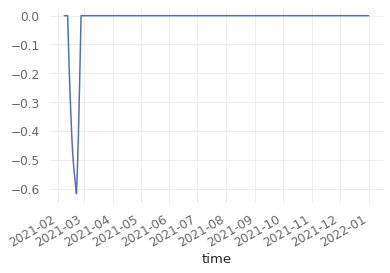

In [15]:
print('Downside Risk', rets_acc.downside_risk())
rets_acc.drawdown().plot()

In [16]:
data['returns_strategy']\
    .vbt.returns\
    .plot_cumulative(benchmark_rets=data['close']
                     .pct_change(1))


FigureWidget({
    'data': [{'line': {'color': '#7f7f7f'},
              'name': 'Benchmark',
              's…